#Introduction
This analysis tries help people who wants to rent a house based in some characteristics to predict the total rent amount.

It can help who needs rent a house because the presense in the house becomes unnecessary, so saves a lot of time.

The target is try to predict the **TOTAL** total rent amount.

In [0]:
import pandas as pd
import zipfile
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [0]:
zf = zipfile.ZipFile('brasilian-houses-to-rent.zip') 
df = pd.read_csv(zf.open('houses_to_rent.csv'))
df = df.drop(['Unnamed: 0'], axis = 1)

#Data

I will use a dataset from Kaggle (https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent).

This dataset have 6079 houses to rent with 13 features:

- city: anonimyzed city where the property is located;
- area: property area (m²);
- rooms: quantity of rooms;
- bathroom: quantity of bathroom;
- parking spaces: quantity of parking spaces;
- floor: floor;
- animal: accept animals?;
- furniture: furniture?;
- hoa (A): homeowners association tax;
- rent amount (B): rent amount;
- property tax (C): property tax;
- fire insurance (D): fire insurance;
- total: total rent (A + B + C + D)

In [163]:
df.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
0,1,240,3,3,4,-,acept,furnished,R$0,"R$8,000","R$1,000",R$121,"R$9,121"
1,0,64,2,1,1,10,acept,not furnished,R$540,R$820,R$122,R$11,"R$1,493"
2,1,443,5,5,4,3,acept,furnished,"R$4,172","R$7,000","R$1,417",R$89,"R$12,680"
3,1,73,2,2,1,12,acept,not furnished,R$700,"R$1,250",R$150,R$16,"R$2,116"
4,1,19,1,1,0,-,not acept,not furnished,R$0,"R$1,200",R$41,R$16,"R$1,257"


##Data Cleaning

In [0]:
#Replace 'Sem info/Incluso' (respectively represents no info/included) and others
df['hoa'] = df['hoa'].replace('Sem info','0')
df['hoa'] = df['hoa'].replace('Incluso','0')
df['animal'] = df['animal'].replace('not acept','0')
df['animal'] = df['animal'].replace('acept','1')
df['furniture'] = df['furniture'].replace('not furnished','0')
df['furniture'] = df['furniture'].replace('furnished','1')
df['property tax'] = df['property tax'].replace('Sem info','0')
df['property tax'] = df['property tax'].replace('Incluso','0')
df['floor'] = df['floor'].replace('-','0')

In [0]:
#Cleaning money reference function
def replace_value(v):
    ret = v.replace('R$', '')
    ret = ret.replace(',', '')
    ret = float(ret)
    return ret

In [0]:
df['hoa'] = df['hoa'].apply(lambda x: replace_value(x))
df['rent amount'] = df['rent amount'].apply(lambda x: replace_value(x))
df['property tax'] = df['property tax'].apply(lambda x: replace_value(x))
df['fire insurance'] = df['fire insurance'].apply(lambda x: replace_value(x))
df['total'] = df['total'].apply(lambda x: replace_value(x))

In [167]:
df.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total
0,1,240,3,3,4,0,1,1,0.0,8000.0,1000.0,121.0,9121.0
1,0,64,2,1,1,10,1,0,540.0,820.0,122.0,11.0,1493.0
2,1,443,5,5,4,3,1,1,4172.0,7000.0,1417.0,89.0,12680.0
3,1,73,2,2,1,12,1,0,700.0,1250.0,150.0,16.0,2116.0
4,1,19,1,1,0,0,0,0,0.0,1200.0,41.0,16.0,1257.0


#Methodology
The first step is the data exploration to understand the data, checking missing data and data balance. Next I will verify if exists any relationship among features and total.

Then I will try predictive models to identify total rent amount and identify features that more influences it.

##Data Exploration

###Check missing data

In [168]:
#Check Missing data
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,total,fire insurance,property tax,rent amount,hoa,furniture,animal,floor,parking spaces,bathroom,rooms,area,city
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###Verify data distribution

In [169]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
city,6080.0,0.863322,0.343535,0.0,1.0,1.0,1.0,1.0
area,6080.0,151.143914,375.559485,10.0,58.0,100.0,200.0,24606.0
rooms,6080.0,2.492599,1.129665,1.0,2.0,3.0,3.0,10.0
bathroom,6080.0,2.341612,1.438860,1.0,1.0,2.0,3.0,10.0
parking spaces,6080.0,1.756250,1.611909,0.0,1.0,1.0,2.0,12.0
hoa,6080.0,1088.426480,3981.357627,0.0,24.5,650.0,1436.0,220000.0
rent amount,6080.0,4395.844408,3576.668946,420.0,1800.0,3111.0,5952.5,45000.0
property tax,6080.0,490.333388,6212.564538,0.0,33.0,145.0,458.0,366300.0
fire insurance,6080.0,58.204276,49.313441,3.0,23.0,41.0,77.0,677.0
total,6080.0,6033.194572,8751.347700,660.0,2451.5,4128.5,8074.0,372700.0


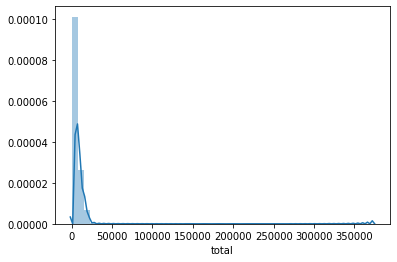

In [170]:
sns.distplot(df["total"])

##Normalize Data
It is necessary remove outliers

In [171]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

city                 0.0
area               142.0
rooms                1.0
bathroom             2.0
parking spaces       1.0
hoa               1411.5
rent amount       4152.5
property tax       425.0
fire insurance      54.0
total             5622.5
dtype: float64


In [0]:
#Removing rows with total > 5622.5
df = df[df['total']<= 5622.5]

In [173]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
city,3849.0,0.814497,0.388755,0.0,1.0,1.0,1.0,1.0
area,3849.0,90.482203,213.623409,10.0,49.0,70.0,102.0,12732.0
rooms,3849.0,2.046246,0.921527,1.0,1.0,2.0,3.0,7.0
bathroom,3849.0,1.651858,0.902107,1.0,1.0,1.0,2.0,7.0
parking spaces,3849.0,1.124188,1.138834,0.0,0.0,1.0,2.0,8.0
hoa,3849.0,533.610288,479.864491,0.0,0.0,484.0,799.0,3398.0
rent amount,3849.0,2282.626916,1037.889167,420.0,1465.0,2100.0,3000.0,5500.0
property tax,3849.0,118.114315,150.761930,0.0,5.0,70.0,167.0,2500.0
fire insurance,3849.0,29.754222,15.378620,3.0,18.0,27.0,39.0,83.0
total,3849.0,2964.571577,1268.934598,660.0,1930.0,2801.0,3974.0,5622.0


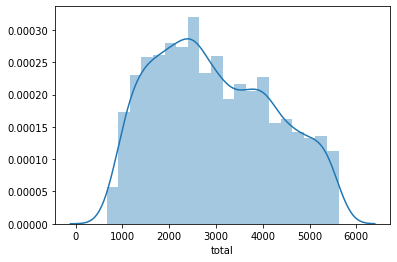

In [174]:
sns.distplot(df["total"])

##Working data

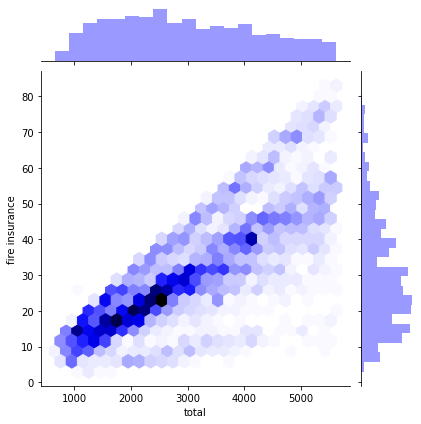

In [175]:
sns.jointplot(df['total'], df['fire insurance'], kind="hex", color="b")

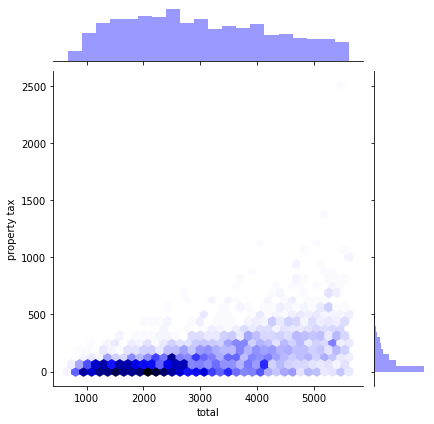

In [176]:
sns.jointplot(df['total'], df['property tax'], kind="hex", color="b")

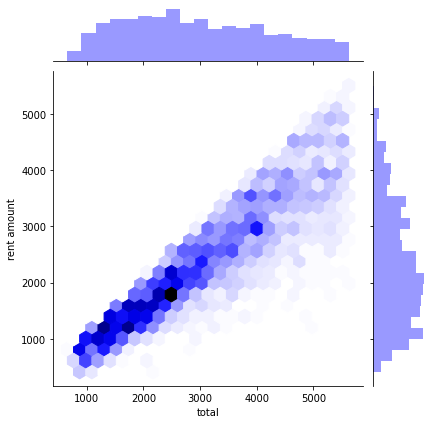

In [177]:
sns.jointplot(df['total'], df['rent amount'], kind="hex", color="b")

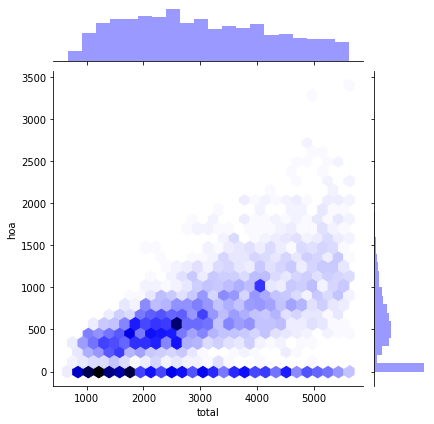

In [178]:
sns.jointplot(df['total'], df['hoa'], kind="hex", color="b")

In [179]:
Feature = df[["city","area","rooms","bathroom","parking spaces","floor","animal","furniture","hoa","fire insurance","rent amount","property tax"]]
Feature.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,fire insurance,rent amount,property tax
1,0,64,2,1,1,10,1,0,540.0,11.0,820.0,122.0
3,1,73,2,2,1,12,1,0,700.0,16.0,1250.0,150.0
4,1,19,1,1,0,0,0,0,0.0,16.0,1200.0,41.0
5,1,13,1,1,0,2,1,0,0.0,28.0,2200.0,42.0
7,1,55,2,2,1,2,1,0,600.0,17.0,1300.0,67.0


In [0]:
X = Feature

In [0]:
y = df[["total"]].values

In [0]:
#Normalize Data
X = preprocessing.StandardScaler().fit(X).transform(X)

##Train Test Split

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (3079, 12) (3079, 1)
Test set: (770, 12) (770, 1)


##Predict with diferent models

###KNN Regressor

In [184]:
#Try identify better K
Ks = 30
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    kneigh = KNeighborsRegressor(n_neighbors = n).fit(X_train,y_train)
    yhatKnn=kneigh.predict(X_test)
    mean_acc[n-1] = metrics.mean_absolute_error(y_test, yhatKnn)

mean_acc

array([251.51038961, 228.23051948, 222.94458874, 218.66168831,
       211.29688312, 218.31320346, 214.97792208, 215.42597403,
       217.11284271, 216.45181818, 218.52998819, 217.89837662,
       220.50669331, 222.46400742, 227.41108225, 230.70625   ,
       234.07135218, 237.19393939, 238.57928913, 240.20545455,
       240.96740878, 243.09155844, 244.27747036, 246.07532468,
       248.24955844, 250.28411588, 253.31996152, 255.47991651,
       256.37908643])

In [190]:
#Using K = 5
k = 5
kneigh = KNeighborsRegressor(n_neighbors = k).fit(X_train,y_train)
yhatKnn = kneigh.predict(X_test)

print("Train set MAE: ", metrics.mean_absolute_error(y_train, kneigh.predict(X_train)))
print("Test set MAE: ", metrics.mean_absolute_error(y_test, yhatKnn))

Train set MAE:  159.87314063007472
Test set MAE:  211.2968831168831


###Decision Tree Regressor

In [191]:
#Decition Tree
for n in range(1,30):
    scoreMathTree = DecisionTreeRegressor(criterion="mse", max_depth = n, max_features = "auto", min_samples_split = 2)
    scoreMathTree.fit(X_train,y_train)
    
    #PREDICTION
    predTree = scoreMathTree.predict(X_test)
    
    #EVALUATION
    print("DecisionTrees's MAE ", n, ": ", metrics.mean_absolute_error(y_test, predTree))

DecisionTrees's MAE  1 :  636.8112097541066
DecisionTrees's MAE  2 :  466.43480052297895
DecisionTrees's MAE  3 :  349.79497054735936
DecisionTrees's MAE  4 :  259.58443549568136
DecisionTrees's MAE  5 :  183.70073590358112
DecisionTrees's MAE  6 :  143.56974593971145
DecisionTrees's MAE  7 :  117.96196764655586
DecisionTrees's MAE  8 :  103.99943828095302
DecisionTrees's MAE  9 :  87.97153634084015
DecisionTrees's MAE  10 :  79.5571278569
DecisionTrees's MAE  11 :  75.22024844061157
DecisionTrees's MAE  12 :  75.43725511390016
DecisionTrees's MAE  13 :  74.72524273345702
DecisionTrees's MAE  14 :  73.93080449107542
DecisionTrees's MAE  15 :  72.0565491651206
DecisionTrees's MAE  16 :  74.49601731601732
DecisionTrees's MAE  17 :  72.12467532467532
DecisionTrees's MAE  18 :  73.50649350649351
DecisionTrees's MAE  19 :  72.6987012987013
DecisionTrees's MAE  20 :  73.91558441558442
DecisionTrees's MAE  21 :  72.12727272727273
DecisionTrees's MAE  22 :  75.83896103896105
DecisionTrees's MA

In [193]:
#Using n = 15
scoreMathTree = DecisionTreeRegressor(criterion="mse", max_depth = 15, max_features = "auto", min_samples_split = 2)
scoreMathTree.fit(X_train,y_train)

#PREDITION
predTree = scoreMathTree.predict(X_test)

#Evaluation
print("DecisionTrees's MAE: ", metrics.mean_absolute_error(y_test, predTree))


DecisionTrees's MAE:  73.74767470624613


###Extra Tree Regressor


In [194]:
#Decition Tree
for n in range(1,30):
    scoreMathExtraTree = DecisionTreeRegressor(criterion="mse", max_depth = n, max_features = "auto", min_samples_split = 2)
    scoreMathExtraTree.fit(X_train,y_train)
    
    #PREDICTION
    predExtraTree = scoreMathExtraTree.predict(X_test)
    
    #EVALUATION
    print("DecisionExtraTrees's MAE ", n, ": ", metrics.mean_absolute_error(y_test, predExtraTree))

DecisionExtraTrees's MAE  1 :  636.8112097541066
DecisionExtraTrees's MAE  2 :  466.43480052297895
DecisionExtraTrees's MAE  3 :  349.79497054735936
DecisionExtraTrees's MAE  4 :  259.58443549568136
DecisionExtraTrees's MAE  5 :  183.70073590358112
DecisionExtraTrees's MAE  6 :  142.4100056799712
DecisionExtraTrees's MAE  7 :  116.8022273868156
DecisionExtraTrees's MAE  8 :  104.18244497123244
DecisionExtraTrees's MAE  9 :  87.76558395988776
DecisionExtraTrees's MAE  10 :  79.41996026258956
DecisionExtraTrees's MAE  11 :  77.1144042847674
DecisionExtraTrees's MAE  12 :  75.55248238662745
DecisionExtraTrees's MAE  13 :  75.60396258503403
DecisionExtraTrees's MAE  14 :  73.8427633655343
DecisionExtraTrees's MAE  15 :  74.030915275201
DecisionExtraTrees's MAE  16 :  74.42207792207792
DecisionExtraTrees's MAE  17 :  71.18181818181819
DecisionExtraTrees's MAE  18 :  71.77532467532467
DecisionExtraTrees's MAE  19 :  70.54935064935064
DecisionExtraTrees's MAE  20 :  73.08311688311689
Decision

In [195]:
#Usin n = 14
scoreMathExtraTree = ExtraTreeRegressor(criterion="mse", max_depth = 14, max_features = "auto", min_samples_split = 2)
scoreMathExtraTree.fit(X_train,y_train)

#PREDITION
predExtraTree = scoreMathExtraTree.predict(X_test)

#EVALUATION
print("Extra Tree Regression's MAE: ", metrics.mean_absolute_error(y_test, predExtraTree))

Extra Tree Regression's MAE:  105.2414730375486


###Random Forest Regressor

In [196]:
regr = RandomForestRegressor(max_depth=30, random_state=42,bootstrap=True,max_features=8)
regr.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [197]:
predrf = regr.predict(X_test)
print("Random Forest Regressor MAE: ", metrics.mean_absolute_error(y_test, predrf))

Random Forest Regressor MAE:  42.4924805194805


#Results
I obtain better results with Random Forest Regressor.
I will show how features influence the predictor.

In [156]:
!pip install shap

In [198]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_train)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train[0,:], feature_names=Feature.columns)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


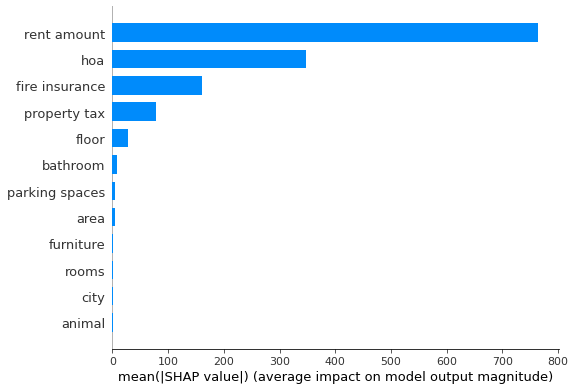

In [199]:
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=Feature.columns)

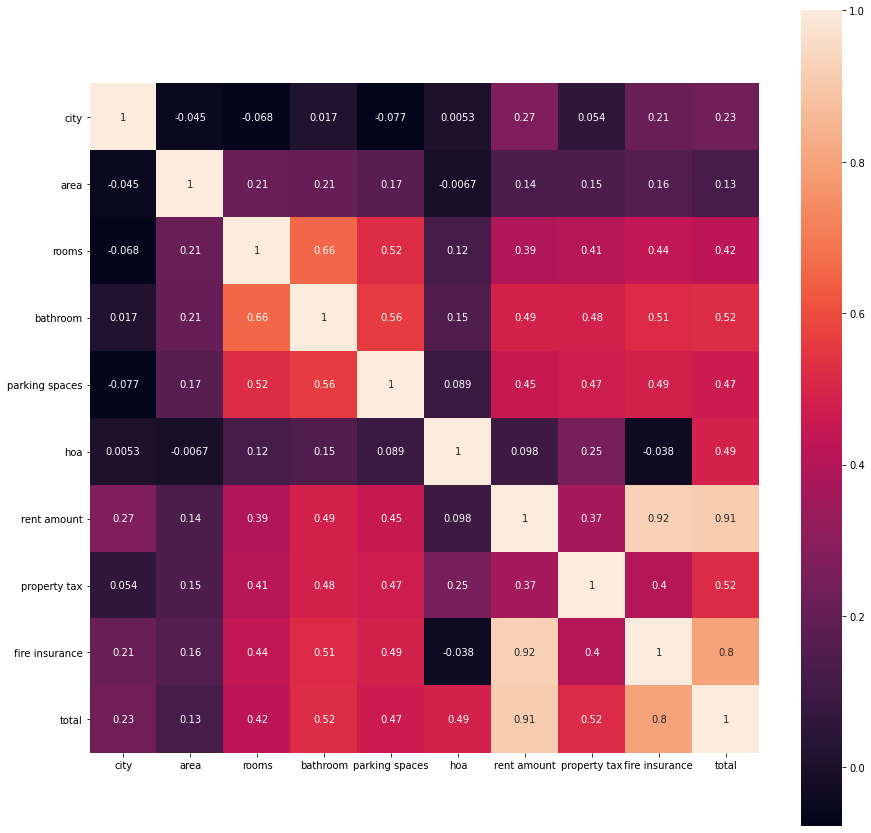

In [159]:
corr = df.corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, annot=True, square=True);